# About the Project
Image Stitching may also be termed as Panorama completion.

Given two or more images of the same scenic view but might be caught from the same or different perspectives of the camera, the resultant image is expected to view the complete scene by merging the images on the basis of common image parts between one-another.

This is commonly coined as the image stitching problem.

In our current exercise, we shall merge two images to form the panorama depicted as follows. We shall mainly use OpenCV with Python and Matplotlib to do this.

a.png

# Check OpenCV Version

First of all, we need to install OpenCv 3.4.2.16.

In [5]:
! pip install opencv-contrib-python==3.4.2.16

In [6]:
import cv2
cv2.__version__

'3.4.2'

# Importing the Modules

We shall next import the necessary modules

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Reading the Images

Now, let us read the images we want to stitch together to create a panorama.

Also, let us display both the left and right images side-by-side.

**Note**:

* `cv2.imread(<< path of the image >>)` is used to read the image in the given path. 
It reads the given image in BGR(Blue, Green, Red) format.

* `plt.imshow` displays data as an image.

* `plt.tight_layout` automatically adjusts subplot params so that the subplot(s) fits in to the figure area.

In [8]:
img_right = cv2.imread('/content/uttower_right.jpg')
# img_right = cv2.imread('/content/nature_right.jpg')

img_left = cv2.imread('/content/uttower_left.jpg')
# img_left = cv2.imread('/content/nature_left.jpg')

plt.figure(figsize=(30,20))

plt.subplot(1,2,1)
plt.title("Left Image")
plt.imshow(img_left) 

plt.subplot(1,2,2)
plt.imshow(img_right)
plt.title("Right Image")

plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

# BGR to RGB and Grayscale

By default, a color image with Red, Green, and Blue channels will be read in reverse order; ie, Blue, Green, and Red by OpenCv.

We could fix this issue by using `cv2.COLOR_BGR2RGB` transformation effect on the image.

So, we shall define a function `fixColor` to return the RGB form of the given image.

Also, let us get the gray-scle form of the two images. Generally, because of the reduced complexity of Grayscale form over the RGB format, grayscale images are preferred to process the images.

**Note**:

*  `cv2.cvtColor()` method is used to convert an image from one color space to another.

*  `cv2.COLOR_BGR2RGB` returns image in RGB format, which was initially in BGR format as read by `cv2.imread()`.

*  `cv2.COLOR_BGR2GRAY` returns image in Grayscale format, which was initially in BGR format as read by `cv2.imread()`.

In [9]:
def fixColor(image):
    return(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

Let us use the `fixColor` function to display the images.

Also, let us get the gray-scle form of the two images. Generally, becuase of the reduced complexity of Grayscale form over  the RGB format, grayscale images are preferred to process the images .

In [10]:
img1 = cv2.cvtColor(img_right,cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img_left,cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(30,20))

plt.subplot(2,2,1)
plt.title("Left Image")
plt.imshow(fixColor(img_left))

plt.subplot(2,2,2)
plt.title("Grayscale of Left Image")
plt.imshow(img2)

plt.subplot(2,2,3)
plt.title("Right Image")
plt.imshow(fixColor(img_right))

plt.subplot(2,2,4)
plt.title("Grayscale of Right Image")
plt.imshow(img1)

plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

# Getting Keypoints and Feature Descriptors

In order to stitch two images, we should first find out the matching image features between both of them, so that we could stitch them based on these features.

Image features are small patches that are useful to compute similarities between images. An image feature is usually composed of a feature keypoint and a feature descriptor.

The key point usually contains the patch 2D position and other stuff if available such as scale and orientation of the image feature.

The descriptor contains the visual description of the patch and is used to compare the similarity between image features.

Let us use [ORB](https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html) algorithm from OpenCV to extract key-points and descriptors for each image. Though there are other alternatives to ORB - like SIFT and SURF - ORB wins over them as it is as efficient as them in computation-wise, performance-wise and ost importantly patent-wise. ORB is free while SIFT and SURF are patented.

**Note**:

*  `cv2.ORB_create()` which creates an object for ORB. We could use this object to get the key-points and descriptors for the images using `detectAndCompute` method of orb object.

In [11]:
orb = cv2.ORB_create(2500)

kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

In [12]:
len(kp1)

2500

# Visualizing Keypoints on the Images

Let us view the original image and the one with key-points marked to see what key-points were extracted.

**Note**:

*  `cv2.drawKeypoints(input_image, input_image_key_points, output_image, color)` method of OpenCV returns the `output_image` drawn with its key-points in given color, given the `input_image` and its key-points `input_image_key_points`, `color` as input arguments.

In [23]:
img_right_kp = cv2.drawKeypoints(img_right, kp1, np.array([]), color=(0,0, 255))
img_left_kp = cv2.drawKeypoints(img_left, kp2, None)

plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
plt.imshow(fixColor(img_left_kp ))

plt.subplot(1,2,2)
plt.imshow(fixColor(img_right_kp ))
plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

In [14]:
type(img_left_kp)

numpy.ndarray

# Getting the Good Matches 

The obtained descriptors in one image are to be recognized in the other image too.  This is because, once the matching features are recognized, the images could be stitched based on these matching features.

Now, we are  mainly going to do the following: 

* **Use  `BFMatcher()`:**

 *  The [Brute-Force matcher](https://docs.opencv.org/3.1.0/dc/dc3/tutorial_py_matcher.html)(`cv2.BFMatcher()`) is simple. It takes the descriptor of one feature in the first set and is matched with all other features in the second set using some distance calculation. And the closest one is returned.

 * For BF matcher, first we have to create the BFMatcher object using `cv2.BFMatcher()`. It takes two optional params:

      *  First param is `normType`: It specifies the distance measurement to be used. For descriptors like ORB, BRIEF, BRISK etc, `cv2.NORM_HAMMING` should be used, which used Hamming distance as measurement.

      * Second param is a boolean variable, `crossCheck`: This is false by default. If it is true, Matcher returns only those matches with value (i,j) such that i-th descriptor in set A has j-th descriptor in set B as the best match and vice-versa. That is, the two features in both sets should match each other. It provides consistent results. On the other hand, SIFT and SURF needs ratio-test to be done unlike ORB. (Often in images, there are tremendous chances where the features may be existing in many places of the image. This may mislead us to use trivial features for our experiment. So we filter out through all the matches to obtain the best ones. So we apply ratio test using the top 2 matches obtained above. We consider a match if the ratio defined below is predominantly greater than the specified ratio. )


* **Use `match` method of `BFMatcher` object:** : By calling this method, we will be returned the best matches.

In [15]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2,)

 `matches` is a list of `DMatch` objects. This DMatch object has the following attributes:

 *  DMatch.distance - Distance between descriptors. The lower, the better it is.
 * DMatch.trainIdx - Index of the descriptor in train descriptors (des1)
 * DMatch.queryIdx - Index of the descriptor in query descriptors (des2)
 * DMatch.imgIdx - Index of the train image(right image)


Now, let us sort them in the order of their distances.

In [16]:
matches = sorted(matches, key = lambda x:x.distance)

# Viewing the Good Matches

Let us view some of the common key-points extracted by the BFMatcher.

From all the keypoints extracted by the BFMatcher, let us plot and view 30 of the best common key-points between the left and right images.

We shall do this in 3 steps:

*  Create a dictionary `draw_params`which mentions the color of the lines marking the matches between the images, and `flags=2` which says to show only those 30 key-points and not any other key-points. (You could experiment this by removing flags)

*  Use `cv2.drawMatches` which returns the image drawn with the 30 common key-points between the right and left images `img_right` and `img_left`, as per the properties mentioned in `draw_params`. We need to pass the `fixColor(img_right), kp1, fixColor(img_left), kp2, matches[:30]` as arguments for this method.

*  Finally, display the image returned by `cv2.drawMatches`  using matplotlib's `plt.imshow`.

Declare the dictionary `draw_params` that mentions the color to be used(`matchColor`) and `flags` value.

Here, we have chosen to use yellow color to draw the matches, and used `flags=2` that indicates to show only those 30 key-points which are being drawn now and don't show others for a neater look.


In [17]:
draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   flags = 2)

matched_features_image = cv2.drawMatches(fixColor(img_right), kp1, fixColor(img_left), kp2, matches[:30], None,**draw_params)
    
plt.figure(figsize=(30,20))
plt.imshow(matched_features_image)

# Finding Homography Matrix

It’s time to align the images now. 

We need to align the images because, though both images could form a panorama,  the two could differ in terms of angle, translation, size, etc, probably caused due to orientational difference in the camera while capturing the photos. Thus, we need to find a transformation matrix to perform this alignment, which ensures compatibility to stitch and form a panorama. 

*A Homography Matrix is a 3x3 transformation matrix that maps the points in one image to the corresponding points in the other image.*

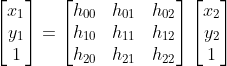

where (x1, y1) and (x2, y2) could be thought of the co-ordinates of the matching key-points in both the images respectively.

A homography matrix is used with the best matching points, to estimate a relative orientation transformation within the two images. Simply put, it is the perspective transformation matrix between two planes - here, the two images.

In order to find a homography matrix, at least 4 matching key-points are needed. 

4kps.png


**Note**:

`cv2.findHomography` finds a perspective transformation between two planes - here, the two images. More [here](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?#findhomography).

`cv2.RANSAC` is a method used to compute a homography matrix. 

  [1]: https://cxl-web-prod-uploads.s3.amazonaws.com/public/pagedown-uploads/83e0e30224033e87d86fdba6857b6eeafe267266.jpg
  [2]: https://cxl-web-prod-uploads.s3.amazonaws.com/public/pagedown-uploads/8a48a90572828774a32dfec4bf60d87b4a7d7882.png

It’s time to align the images now. 

A homography matrix is needed to perform the transformation of one image so as to align it in a compatible way for stictching it with the other. 

This is because, though both images could form a panorama upon stitching together, the two could differ in terms of angle, translation, size, etc. A homography matrix will be used with best matching points, to estimate a relative orientation transformation within the two images. 

A homography matrix requires at least 4 matches, we do the following. Find more [here](https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/).

In [18]:
if len(matches) >= 4:
    src = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)

    H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
else:
    raise AssertionError("Can't find enough keypoints.") 	

# Image Registration

Now that we found the homography for transformation, we can now proceed to warp and display the right-side image in an orientation suitable to be stitched with the left image. This is also known as image registration.

**Note**:

`cv2.warpPerspective` applies a perspective transformation to an image, given the image, homography matrix, and size of the output image and returns the transformed output image.

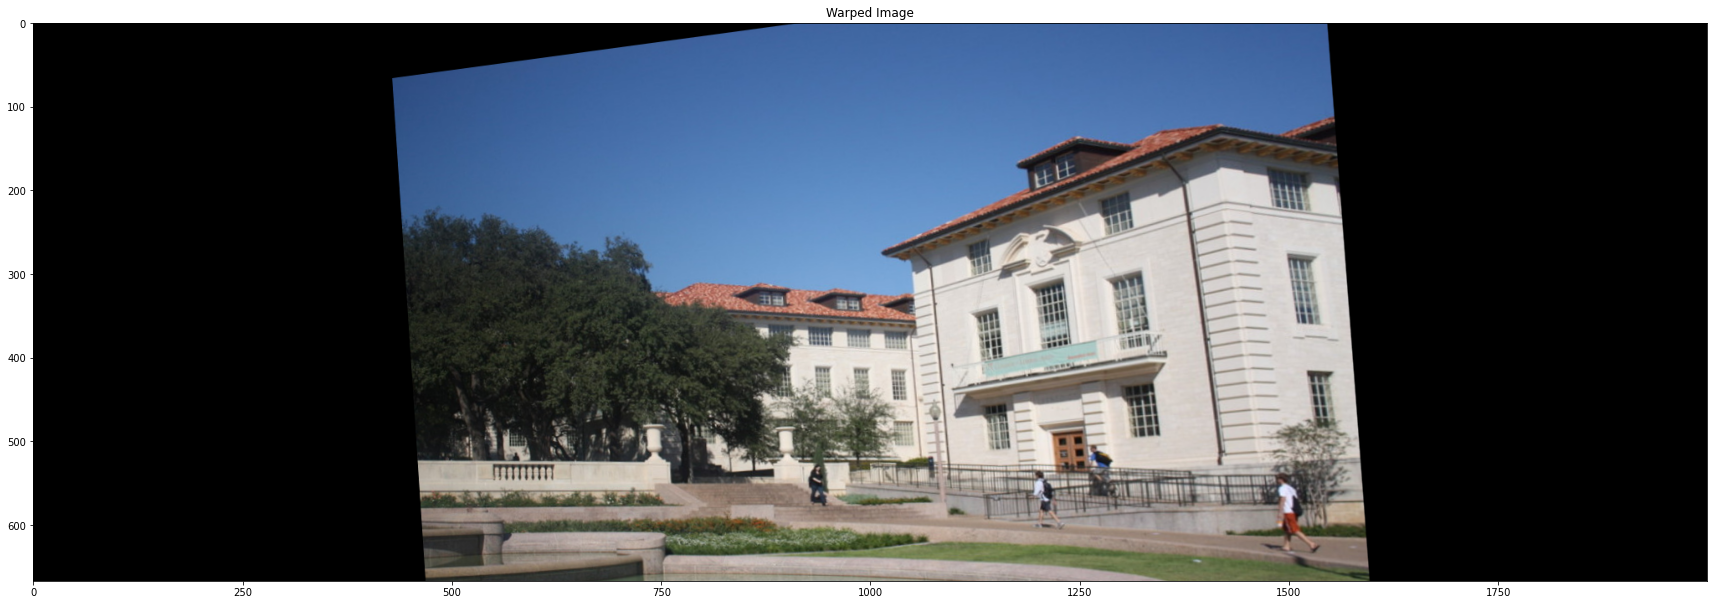

In [19]:
dst = cv2.warpPerspective(img_right,H,(img_left.shape[1] + img_right.shape[1], img_left.shape[0]))    

plt.figure(figsize=(30,20))
plt.title('Warped Image')
plt.imshow(fixColor(dst))

In [20]:
dst.shape

(667, 2000, 3)

# Stitching the Images

And finally comes the last part, the stitching of the images.

We shall place the left image on the `dst` whose shape is left-image width plus right-mage width.

Then, we shall save the resultant file - the final stitched panorama image - and display it. 

**Note**:

`cv2.imwrite` method saves the given image as a file with the given name.

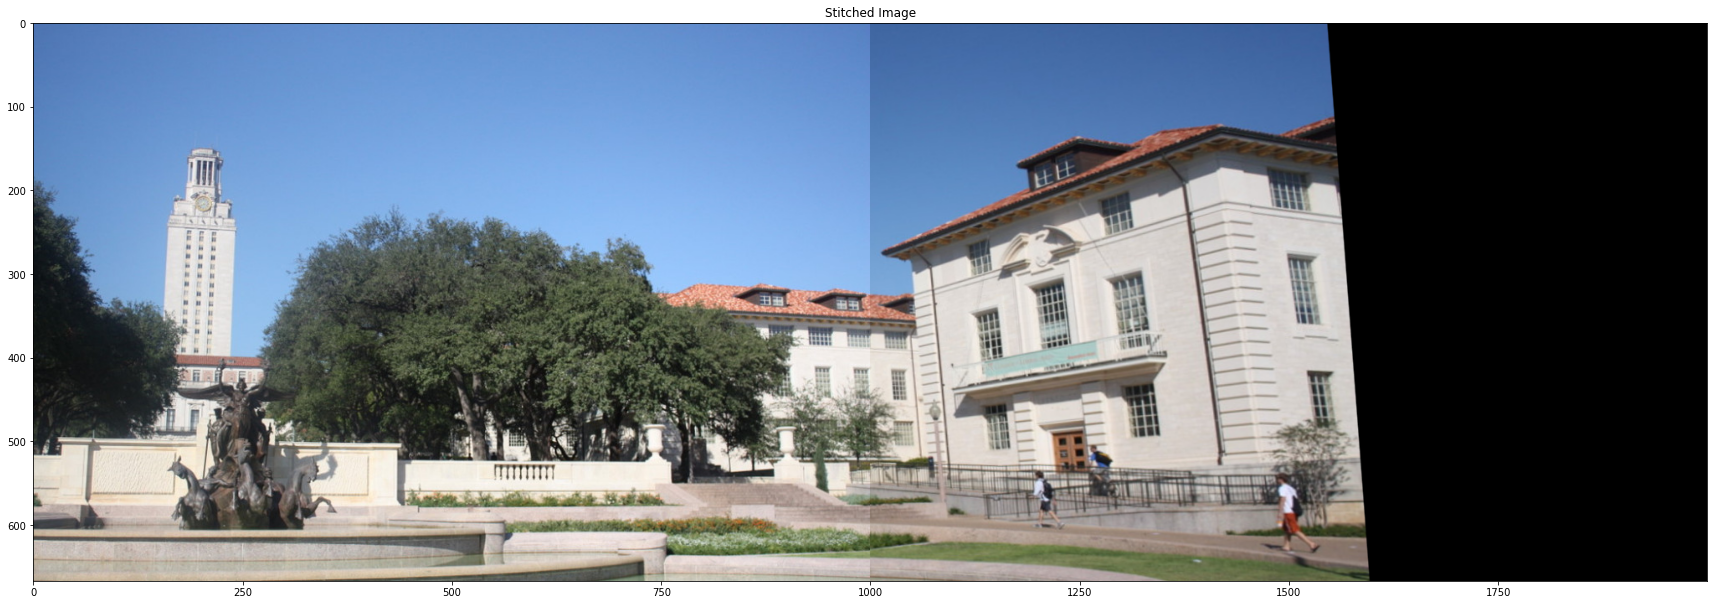

In [21]:
dst[0:img_left.shape[0], 0:img_left.shape[1]] = img_left

cv2.imwrite('resultant_stitched_panorama.jpg',dst)

plt.figure(figsize=(30,20))
plt.title('Stitched Image')
plt.imshow(fixColor(dst))


`dst = cv2.warpPerspective(img_right,H,(img_left.shape[1] + img_right.shape[1], img_left.shape[0]))`

`dst[0:img_left.shape[0], 0:img_left.shape[1]] = img_left`

In above two lines of code we are taking overlapping area from two given images. Then in “dst” we have received only right side of image which is not overlapped, so in second line of code we are placing our left side image to final image. So at this point we have fully stitched image:

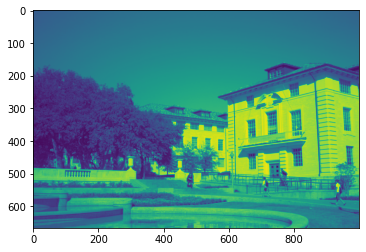

In [22]:
plt.imshow(img1)